In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cvxpy as cp
import mosek

In [5]:
gauss_x = np.arange(-4,4,0.0001)     #### Pre-calculations for generating replicating portfolio's
gauss_y = np.zeros(len(gauss_x))
for i in range(len(gauss_x)):
    gauss_y[i] = norm.cdf(gauss_x[i])

def gauss_cdf(x):
    if np.abs(x) > 4:
        return(norm.cdf(x))
    else:
        return np.interp(x,gauss_x,gauss_y)

In [7]:
# Delta Hedging Error Simulation
def delta_hedging(S, K, r,mu, sigma, T,k0,k, num_steps):
    dt = T / num_steps
    d1 = (np.log(S / K) + (mu + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    cash = -K * np.exp(-r * T) * gauss_cdf(d2)

    # Delta hedging loop
    for i in range(1, num_steps):
        S_new = S * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal())
        d1_new = (np.log(S_new / K) + (r + 0.5 * sigma**2) * (T-i*dt)) / (sigma * np.sqrt(T-i*dt))   
        dd1 = (gauss_cdf(d1_new)-gauss_cdf(d1))
        cash_new = np.exp(r*dt) * cash - S_new * (dd1 + k*np.abs(dd1)) -k0
        S = S_new
        d1 = d1_new
        cash = cash_new
    S_pos = gauss_cdf(d1) * S
    Bond_pos = cash
    S_new = S * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal())
    
    
    return(np.abs(np.maximum(S_new-K,0)-S_pos-Bond_pos))
        

In [147]:
S0 = 1  # Initial stock price
K = 1   # Strike price
mu = 0.05  # Price drift
r = 0.01    # risk-free rate
sigma = 0.3  # Volatility
T = 1.0  # Time to maturity
k0 = 0.0002
k = 0.005
N = 8000
d_steps = np.arange(20,620,20)

In [11]:
hedge_data = np.loadtxt("hedge_data_8000.txt")

In [15]:
np.random.seed(3)
#### run this code if hedge_data needs to be generated
hedge_data = np.zeros((len(d_steps), N))
for i in range(len(d_steps)):
    print(i)
    for j in range(N):
        hedge_data[i,j] = delta_hedging(S0, K, r,mu, sigma, T,k0,k, d_steps[i])
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [23]:
np.savetxt('hedge_data_8000.txt', hedge_data)

In [13]:
def f_explog(x,a,b):   #### default: a=0.1, b=2
    if x > 0 :
        e = np.exp(1)
        ### constants calculations
        
        c1 = 1/(b**2*(a**2+a)*np.exp(a-1))
        c2 = 1 - np.exp(a)*(a*b+1)*c1
        c3 = -np.exp(a+1)*c1
        term = (x+e)*np.exp(a*np.log(x+e)**b) 
        return(c1*term + c2*x + c3)
    else:
        return(np.exp(x)-1)
    
def df_explog(x,a,b):
    if x > 0:
        e = np.exp(1)
        ### constants calculations
        
        c1 = 1/(b**2*(a**2+a)*np.exp(a-1))
        c2 = 1 - np.exp(a)*(a*b+1)*c1
        term = np.exp(a*(np.log(x+e))**b)*(a*b*(np.log(x+e))**(b-1)+1)
        return(c1*term + c2)
    else:
        return(np.exp(x))
    
    
def ddf_explog(x,a,b):
    if x > 0:
        e = np.exp(1)
        c1 = 1/(b**2*(a**2+a)*np.exp(a-1))
        
        term1 = a*b/(x+e)*np.exp(a*np.log(x+e)**b)
        term2 = (b-1)*np.log(x+e)**(b-2) + np.log(x+e)**(b-1) + a*b*np.log(x+e)**(2*b-2)
        return(c1*term1*term2)
    else:
        return(np.exp(x))
    
    
def CVaR(x,alpha):
    return np.maximum(1/alpha*x,0)

def dCVaR(x,alpha):
    if x > 0:
        return(1/alpha)
    else:
        return(0)

def KL(x):
    return np.exp(x)-1

    
    
def log_bar(x):
    if x>0:
        return(-np.log(x))
    else:
        return np.inf
    
def cvar_fast(alpha,x,f):
    n = len(f)
    order = np.argsort(x)
    x = np.sort(x)
    f = f[order]
    csum = np.cumsum(f)
    if csum[0] > alpha:
        return(x[0])
    else:
        k_max = np.max(np.where((csum < alpha)==True))
    Ex = np.sum(np.multiply(x[0:k_max+1],f[0:k_max+1]))
    last = (alpha - csum[k_max])*x[k_max+1]
    return(-1/alpha*(Ex+last))
    


In [15]:

def f_lexp(x,X,alpha,a,b,r):
    the1 = x[0]
    the2 = x[1]
    lbda = x[2]
    N = len(X)
    s1 = 0
    for i in range(N):
        arg = CVaR(the2-X[i],alpha)
        s1 = s1 + lbda * f_explog((arg+the1)/lbda,a,b)
    return(s1/N-the1-the2+lbda*r)

def grad_flexp(x,X,alpha,a,b,r):
    the1 = x[0]
    the2 = x[1]
    lbda = x[2]
    N = len(X)
    grad = np.zeros(3)
    s1 = 0
    s2 = 0
    s3 = 0
    for i in range(N):
        arg = CVaR(the2-X[i],alpha)
        s1 = s1 + df_explog((arg+the1)/lbda,a,b)
        s2 = s2 + df_explog((arg+the1)/lbda,a,b)* dCVaR(the2-X[i],alpha)
        s3 = s3 + f_explog((arg+the1)/lbda,a,b) - df_explog((arg+the1)/lbda,a,b) * ((arg+the1)/lbda)
    
    grad[0] = -1 + s1/N
    grad[1] = -1 + s2/N
    grad[2] = r + s3/N
    return(grad)

def f_constr(x):
    return -x[2]

def grad_f_constr(x):
    return np.array([0,0,-1])

In [39]:
def ellipsoid_constr_method(f_obj, f_constr, grad_f, grad_f_constr, x0, max_iter, r_e, para):
    n = len(x0)
    x = x0
    P = np.identity(n)*r_e
    a,b,alpha,r,X = para
    f_best = f_obj(x0,X,alpha,a,b,r)
    x_opt = x0
    
    for i in range(max_iter):
        # Calculate the subgradient at the current point.
        if x[2] >= 0:
            g = grad_f(x,X,alpha,a,b,r)
            n_g =np.sqrt((g.dot(P)).dot(g)) 
            g_n = g/n_g
            alfa = (f_obj(x,X,alpha,a,b,r)-f_best)/n_g
        else:
            g = grad_f_constr(x)
            #print('constr_g', (g.dot(P)).dot(g))
            n_g =np.sqrt((g.dot(P)).dot(g)) 
            g_n = g/n_g
            alfa = (f_constr(x))/n_g
        
        # normalize subgradient.
        alfa = 0
    
        # Update the ellipsoid parameters.
        U = g_n.dot(P)
        c1 = (n**2/(n**2-1)) * (1-alfa**2)
        c2 = (1+n*alfa)/((n+1)*(1+alfa))*2
        x = x - (1+n*alfa)/(n+1)* P.dot(g_n)
        P = c1 * (P - c2 * np.outer(U,U))
        #print('x', x)
            
        if f_obj(x,X,alpha,a,b,r) < f_best and x[2] >= 0:
            f_best = f_obj(x,X,alpha,a,b,r)
            x_opt = x
            x_grad = grad_f(x,X,alpha,a,b,r)
        #print('obj', f_best, 'sol', x_opt, np.max(P))
        
        if np.max(P) <= 1e-5:
            print('obj', f_best, 'sol', x_opt,'grad', x_grad,'P-norm', np.max(P))
            return(x_opt, f_best, x_grad)
    print('max iterations reached')

    return x_opt, f_best

In [149]:
a = 1/(2*(sigma*2)**2)
b = 2
alpha = 0.05
radius = 0.1

In [151]:
#### run this code to calculate the robust hedging error and nominal hedging error

h_rob = np.zeros(len(d_steps))
h_e = np.zeros(len(d_steps))
for i in range(len(d_steps)):
    print(i)
    N_data = len(hedge_data[i])
    X = -hedge_data[i]
    para = [a,b,alpha,radius,X]
    x0 = np.array([-1,1,5])
    h_e[i] = cvar_fast(alpha,-hedge_data[i],np.zeros(N_data)+ 1/N_data)
    h_rob[i] = ellipsoid_constr_method(f_lexp, f_constr, grad_flexp, grad_f_constr, x0, 400, 1000, para)[1]

0
obj 0.4313624178748915 sol [-0.05945537 -0.20874395  1.57593807] grad [ 1.02381173e-04  1.27200100e-04 -3.89974510e-05] P-norm 8.405107585954953e-06
1
obj 0.24959378083504347 sol [-0.02081756 -0.17938534  0.48274783] grad [ 3.63720562e-06 -1.56330767e-04  4.21459416e-05] P-norm 9.081687339770806e-06
2
obj 0.1994195911477967 sol [-0.01492433 -0.15076264  0.33080326] grad [ 3.95106186e-05  1.43774108e-04 -3.82106959e-05] P-norm 8.446949100681771e-06
3
obj 0.17702405907424432 sol [-0.01242223 -0.13499168  0.28913013] grad [ 5.35118493e-05  2.16590566e-04 -4.31503217e-05] P-norm 7.501252129184203e-06
4
obj 0.18764035034848173 sol [-0.0181973  -0.12513775  0.43216939] grad [-8.67134370e-05 -2.10539194e-03  1.90031114e-04] P-norm 5.9188883211104265e-06
5
obj 0.171949062951 sol [-0.01269892 -0.1293707   0.29219301] grad [ 9.26360015e-05  8.57228216e-04 -6.81966655e-05] P-norm 6.6254271007221606e-06
6
obj 0.1714619355889669 sol [-0.01313475 -0.1245959   0.32678064] grad [ 0.00023659 -0.00079

In [171]:
np.savetxt('h_rob.txt', h_rob)
np.savetxt('h_e.txt', h_e)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


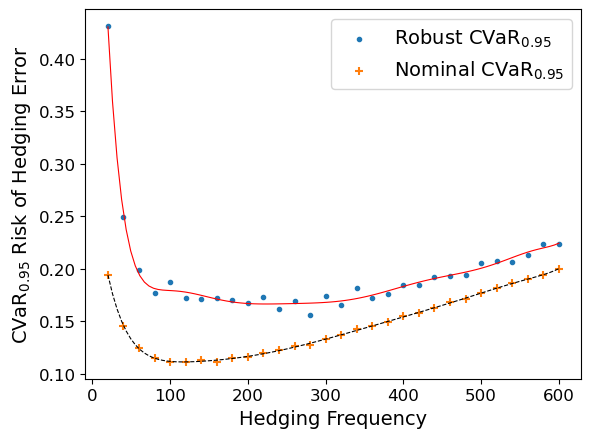

In [169]:
coefficients_rob = np.polyfit(d_steps, h_rob, 10)
coefficients_nom = np.polyfit(d_steps, h_e, 10)

# Generate points for the fitted curve
x_fit_rob = np.linspace(d_steps.min(), d_steps.max(), 100)
y_fit_rob = np.polyval(coefficients_rob, x_fit_rob)

x_fit_nom = np.linspace(d_steps.min(), d_steps.max(), 100)
y_fit_nom = np.polyval(coefficients_nom, x_fit_nom)

# Observed data
plt.scatter(d_steps, h_rob, label=r'Robust $\mathrm{CVaR}_{0.95}$', marker = '.')
plt.scatter(d_steps, h_e, label=r'Nominal $\mathrm{CVaR}_{0.95}$', marker = '+')

# Fitted Data
plt.plot(x_fit_rob, y_fit_rob, color='red', linewidth=0.8)
plt.plot(x_fit_nom, y_fit_nom, color='black', linewidth=0.8, linestyle='--')

plt.xlabel('Hedging Frequency', fontsize=14)
plt.ylabel(r'$\mathrm{CVaR}_{0.95}$ Risk of Hedging Error', fontsize=14)
plt.xticks(fontsize=12)  # Set font size for x-axis ticks
plt.yticks(fontsize=12)  # Set font size for y-axis ticks
plt.legend(fontsize=14)  # Set font size for legend

plt.savefig('BlackScholes.eps', format = 'eps')